In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import espra_Rc

In [2]:
def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    if Q[0,0] < 0:
        Q = -Q

    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):
        return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, q11=1., q22=1., q12=0.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0

    X = np.stack([x_2d - x_c, y_2d - y_c], axis=0) 
    Q = np.array([[q11, q12], [q12, q22]]) 
    
    r_c = np.sqrt(np.einsum('i...,ij,j...->...', X, Q, X))

    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy()

## DOPPIO

In [3]:
def find_root(x, y, degree=3):
    """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
    coeffs = np.polyfit(x, y, degree)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid_x = x[len(x) // 2]
    return real_roots[np.argmin(np.abs(real_roots - mid_x))]

def tangent_at_root(x, y, root_x, degree=3):
    coeffs = np.polyfit(x, y, degree)
    slope = np.polyval(np.polyder(coeffs), root_x)
    intercept = np.polyval(coeffs, root_x) - slope * root_x
    y_fit = np.polyval(coeffs, x)
    r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
    return slope, intercept, r2

def doppio(nic, njc, r, u, v, X, Y):

    # Vertical profile along column njc
    u1 = u[nic - r: nic + r + 1, njc]
    v1 = v[nic - r: nic + r + 1, njc]
    x1 = X.T[nic - r: nic + r + 1, njc]
    y1 = Y.T[nic - r: nic + r + 1, njc]
    center_x = X.T[nic, njc]
    xx = x1 - center_x

    # Horizontal profile along row nic
    u2 = u[nic, njc - r: njc + r + 1]
    v2 = v[nic, njc - r: njc + r + 1]
    x2 = X.T[nic, njc - r: njc + r + 1]
    y2 = Y.T[nic, njc - r: njc + r + 1]
    center_y = Y.T[nic, njc]
    yy = y2 - center_y

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom + center_x
    y0 = (beta * gamma - alpha * B1) / denom + center_y
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    # Remove duplicates from (x1, y1, u1, v1)
    points1 = set(zip(x1, y1))
    points2 = set(zip(x2, y2))
    common_points = points1 & points2
    mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
    x1f = x1[mask]
    y1f = y1[mask]
    u1f = u1[mask]
    v1f = v1[mask]
    
    # Concatenate with unaltered second set
    xi = np.concatenate([x1f, x2])
    yi = np.concatenate([y1f, y2])
    ui = np.concatenate([u1f, u2])
    vi = np.concatenate([v1f, v2])

    Rc_opt, psi0_opt = espra_Rc(xi, yi, ui, vi, x0, y0, q11, q12, q22)

    return x0, y0, w, Q, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy, Rc_opt, psi0_opt


In [4]:
X, Y = np.meshgrid(x, y)
nic, njc = 53, 53
r = 5

df_tests = pd.DataFrame({
    'nic': [nic, 42, 39, nic, nic, nic],
    'njc': [njc, 58, 39, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():
    x0_rel, y0_rel, w_rel, Q_rel, x1_rel, y1_rel, u1_rel, v1_rel, x2_rel, y2_rel, u2_rel, v2_rel, xx_rel, yy_rel, Rc_rel, psi0_rel = doppio(nic_rel, njc_rel, r_rel, u, v, X, Y)
    
    dic_tests[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'w': w_rel, 'Q': Q_rel, 'x1': x1_rel, 'y1': y1_rel,
        'u1': u1_rel, 'v1': v1_rel, 'x2': x2_rel, 'y2': y2_rel,
        'u2': u2_rel, 'v2': v2_rel, 'xx': xx_rel, 'yy': yy_rel, 'name': test_name,
        'Rc': Rc_rel, 'psi0': psi0_rel
    }

In [5]:
df_tests['x']= x[df_tests['nic']]
df_tests['y']= y[df_tests['njc']]
df_tests

,nic,njc,r,x,y
P1,53,53,5,15.0,15.0
P2,42,58,5,-40.0,40.0
P3,39,39,5,-55.0,-55.0
L1,53,53,3,15.0,15.0
L2,53,53,5,15.0,15.0
L3,53,53,7,15.0,15.0


Rc: 15.44941636877499 psi0 241.3840790255074
-0.019724209306378526 -0.019724209306378526
Rc: 9.948656562328857 psi0 120.67719667147537
-4.039353864131108 4.0393538641316695
Rc: 8.573261718596331 psi0 62.90411231844483
-12.867740705537457 -12.867740705537457
Rc: 15.44941636877499 psi0 241.3840790255074
Rc: 9.948656562328857 psi0 120.67719667147537
Rc: 8.573261718596331 psi0 62.90411231844483


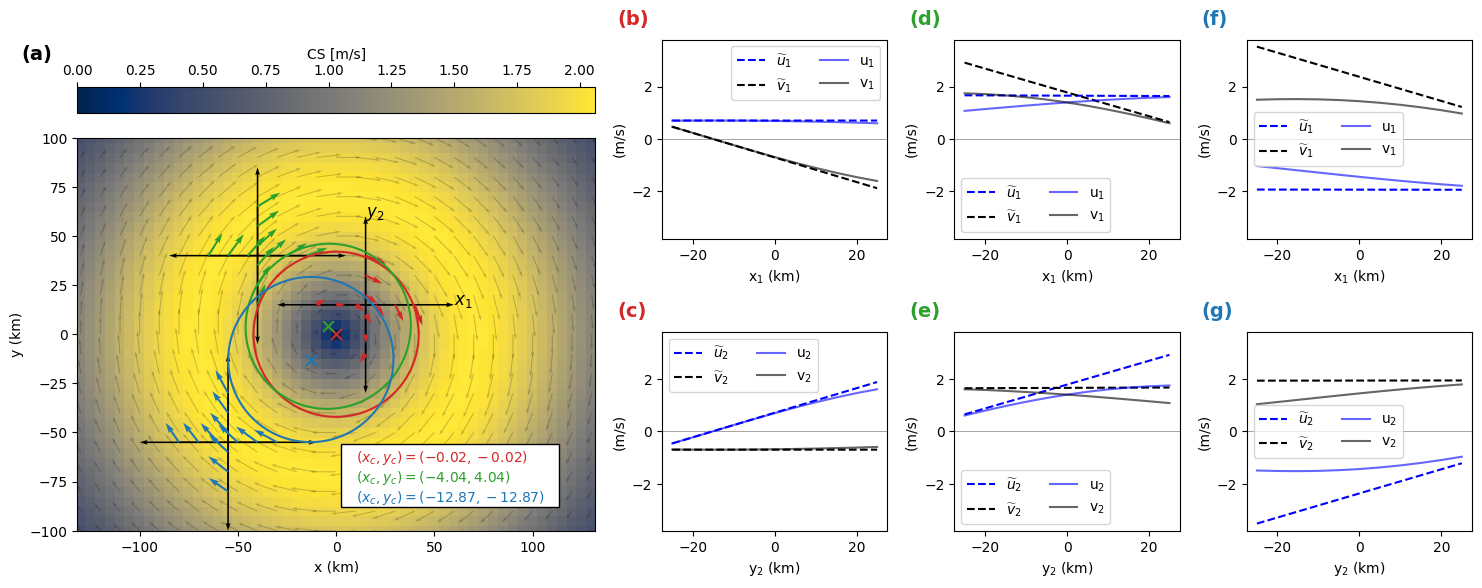

In [6]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, Q, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy, Rc, psi0 = (dic[k] for k in ['x0', 'y0', 'w', 'Q', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy', 'Rc', 'psi0'])
        print('Rc:', Rc, 'psi0', psi0)
        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i])

        x_ellipse, y_ellipse = plot_ellipse(Q, center=(x0, y0), scale=50)
        ax_main.plot(x_ellipse, y_ellipse, color=colours[i])
        
        ax_main.text(10, -65 - 10*i, fr'$(x_c,y_c)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(f)','(g)'), ('(d)','(e)')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy, Rc, psi0 = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy', 'Rc', 'psi0'])
        print('Rc:', Rc, 'psi0', psi0)
        
        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0, _ = tangent_at_root(xx, u1, root_x)
        B1, B0, _ = tangent_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0, _ = tangent_at_root(yy, u2, root_y)
        D1, D0, _ = tangent_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--', label=r'$\widetilde{u}_1$')
        ax2.plot(xx, p_v1, 'k--', label=r'$\widetilde{v}_1$')
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best', ncol=2)
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'b--', label=r'$\widetilde{u}_2$')
        ax3.plot(yy, p_v2, 'k--', label=r'$\widetilde{v}_2$')
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best', ncol=2)
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
  
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

Rc: 15.3916911493452 psi0 239.3980634718521
0.007482736633351195 0.007482736633351195
Rc: 15.44941636877499 psi0 241.3840790255074
-0.019724209306378526 -0.019724209306378526
Rc: 15.45156060815863 psi0 241.93688235090374
-0.04800732223571913 -0.04800732223571913
Rc: 15.3916911493452 psi0 239.3980634718521
Rc: 15.44941636877499 psi0 241.3840790255074
Rc: 15.45156060815863 psi0 241.93688235090374


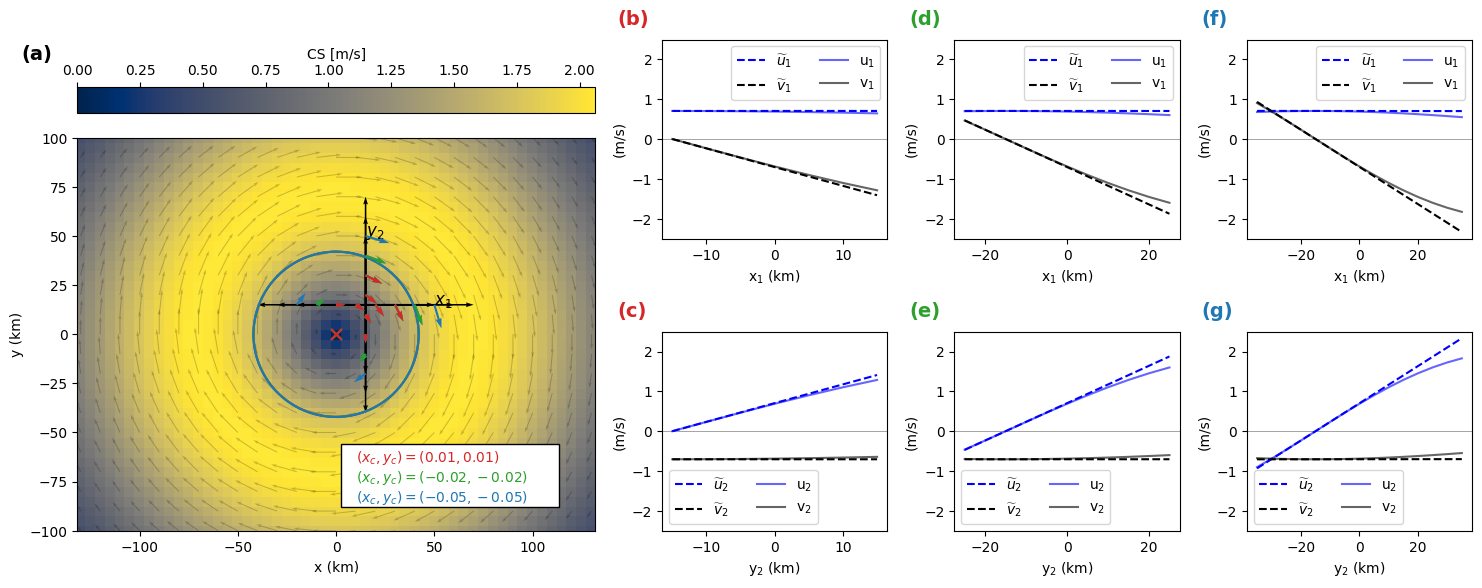

In [7]:
fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:

        x0, y0, w, Q, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy, Rc, psi0 = (dic[k] for k in ['x0', 'y0', 'w', 'Q', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy', 'Rc', 'psi0'])
        print('Rc:', Rc, 'psi0', psi0)
        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))

        x_ellipse, y_ellipse = plot_ellipse(Q, center=(x0, y0), scale=50)
        ax_main.plot(x_ellipse, y_ellipse, color=colours[i])
        
        ax_main.text(10, -65 - 10*i, fr'$(x_c,y_c)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(f)','(g)'), ('(d)','(e)')]
for dic in dic_tests.values():
    if 'L' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy, Rc, psi0 = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy', 'Rc', 'psi0'])
        print('Rc:', Rc, 'psi0', psi0)
        
        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0, _ = tangent_at_root(xx, u1, root_x)
        B1, B0, _ = tangent_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0, _ = tangent_at_root(yy, u2, root_y)
        D1, D0, _ = tangent_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--', label=r'$\widetilde{u}_1$')
        ax2.plot(xx, p_v1, 'k--', label=r'$\widetilde{v}_1$')
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best', ncol=2)
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'b--', label=r'$\widetilde{u}_2$')
        ax3.plot(yy, p_v2, 'k--', label=r'$\widetilde{v}_2$')
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best', ncol=2)
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [8]:
df = pd.DataFrame(columns=['x0', 'y0'])
for dic in dic_tests.values():
    df.loc[len(df)] = {'x0': dic['x0'], 'y0': dic['y0']}
df.index = dic_tests.keys()

df

,x0,y0
P1,-0.019724,-0.019724
P2,-4.039354,4.039354
P3,-12.867741,-12.867741
L1,0.007483,0.007483
L2,-0.019724,-0.019724
L3,-0.048007,-0.048007


# Elliptical Vortex with Modifications


In [9]:
u, v, _, _ = calculate_eddy(q11=2, q22=2, q12=1)

In [10]:
X, Y = np.meshgrid(x, y)
nic, njc = 53, 53
r = 5

df_tests = pd.DataFrame({
    'nic': [nic, 42, 39, nic, nic, nic],
    'njc': [njc, 58, 39, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():
    x0_rel, y0_rel, w_rel, Q_rel, x1_rel, y1_rel, u1_rel, v1_rel, x2_rel, y2_rel, u2_rel, v2_rel, xx_rel, yy_rel, Rc_rel, psi0_rel = doppio(nic_rel, njc_rel, r_rel, u, v, X, Y)
    
    dic_tests[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'w': w_rel, 'Q': Q_rel, 'x1': x1_rel, 'y1': y1_rel,
        'u1': u1_rel, 'v1': v1_rel, 'x2': x2_rel, 'y2': y2_rel,
        'u2': u2_rel, 'v2': v2_rel, 'xx': xx_rel, 'yy': yy_rel, 'name': test_name,
        'Rc': Rc_rel, 'psi0': psi0_rel
    }



Rc: 15.445929408129931 psi0 239.46507672511396
0.013369631894477152 0.013369631894477152
Rc: 8.880330207389685 psi0 89.25572746268554
-0.7547360744246916 0.7547360744247413
Rc: 10.785813285076857 psi0 140.10444492083636
-18.68764509995333 -18.68764509995333
Rc: 15.445929408129931 psi0 239.46507672511396
Rc: 8.880330207389685 psi0 89.25572746268554
Rc: 10.785813285076857 psi0 140.10444492083636


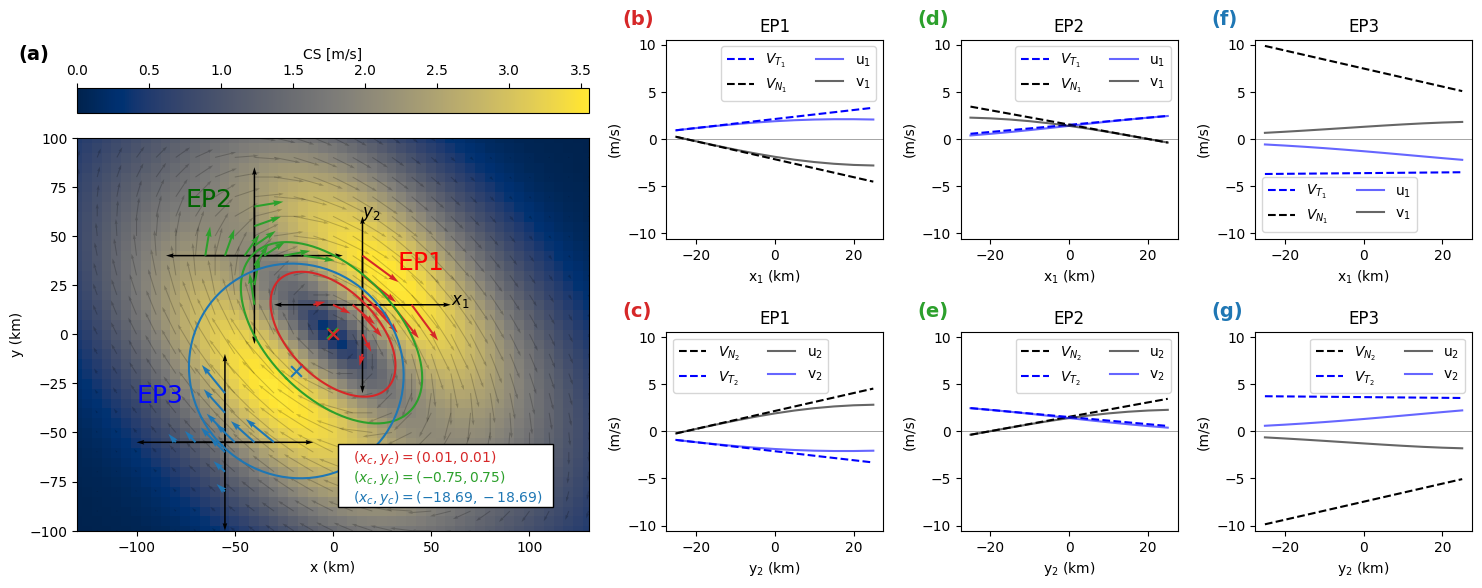

In [14]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
scales = [40, 58, 65]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, Q, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy, Rc, psi0 = (dic[k] for k in ['x0', 'y0', 'w', 'Q', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy', 'Rc', 'psi0'])
        print('Rc:', Rc, 'psi0', psi0)
        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))

        x_ellipse, y_ellipse = plot_ellipse(Q, center=(x0, y0), scale=scales[i])
        ax_main.plot(x_ellipse, y_ellipse, color=colours[i])
        
        ax_main.text(10, -65 - 10*i, fr'$(x_c,y_c)=({x0:.2f},{y0:.2f})$', color=colours[i], zorder=11)
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black', zorder=10)
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)', 'EP1'), ('(f)','(g)', 'EP3'), ('(d)','(e)', 'EP2')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy, Rc, psi0 = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy', 'Rc', 'psi0'])
        print('Rc:', Rc, 'psi0', psi0)
        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0, _ = tangent_at_root(xx, u1, root_x)
        B1, B0, _ = tangent_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0, _ = tangent_at_root(yy, u2, root_y)
        D1, D0, _ = tangent_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--', label=r'$V_{T_1}$')
        ax2.plot(xx, p_v1, 'k--', label=r'$V_{N_1}$')
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best', ncol=2)
        ax2.set_title(tags[2-j][2])
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'k--', label=r'$V_{N_2}$')
        ax3.plot(yy, p_v2, 'b--', label=r'$V_{T_2}$')
        ax3.plot(yy, u2, 'k', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'b', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best', ncol=2)
        ax3.set_title(tags[2-j][2])
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

ax_main.text(33, 33, 'EP1', color='r', zorder=3, fontsize=18)
ax_main.text(-75, 65, 'EP2', color='darkgreen', zorder=3, fontsize=18)
ax_main.text(-100, -35, 'EP3', color='b', zorder=3, fontsize=18)


plt.tight_layout()
plt.show()


Rc: 15.24454142278626 psi0 232.50255870750019
0.17739536970799286 0.17739536970799286
Rc: 15.445929408129931 psi0 239.46507672511396
0.013369631894477152 0.013369631894477152
Rc: 15.471775997254078 psi0 242.57652750408042
-0.17663705389286655 -0.17663705389286655
Rc: 15.24454142278626 psi0 232.50255870750019
Rc: 15.445929408129931 psi0 239.46507672511396
Rc: 15.471775997254078 psi0 242.57652750408042


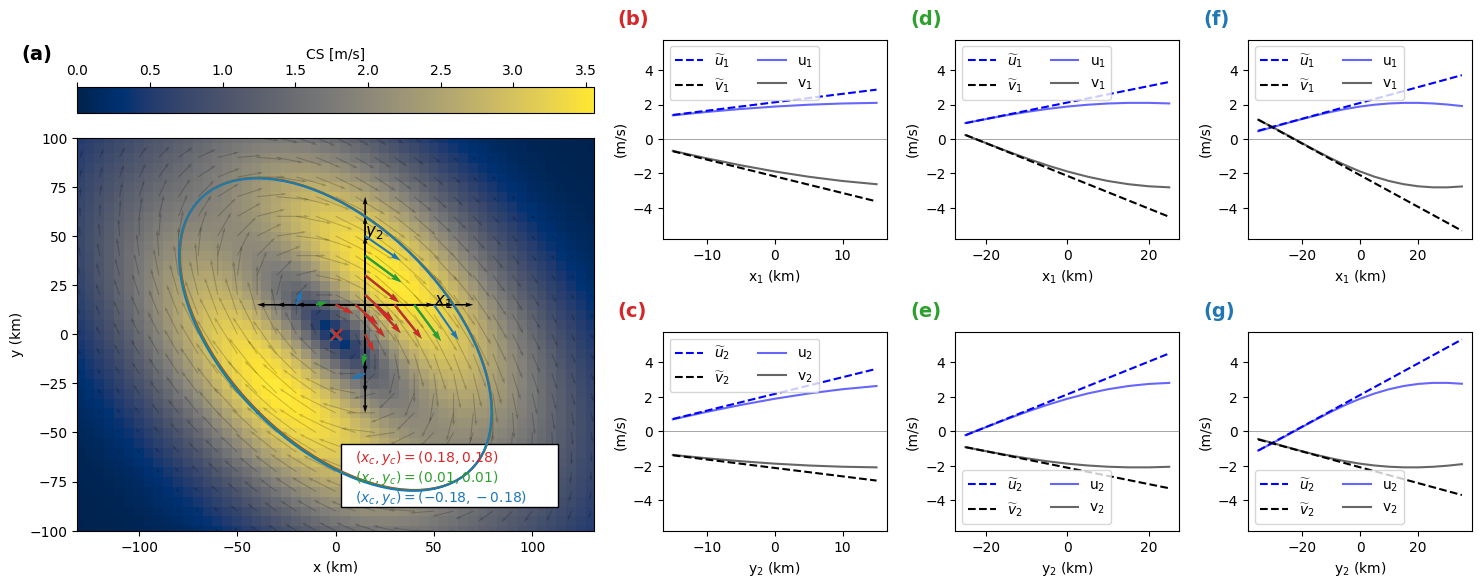

In [12]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:

        x0, y0, w, Q, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy, Rc, psi0 = (dic[k] for k in ['x0', 'y0', 'w', 'Q', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy', 'Rc', 'psi0'])
        print('Rc:', Rc, 'psi0', psi0)
        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))

        x_ellipse, y_ellipse = plot_ellipse(Q, center=(x0, y0), scale=100)
        ax_main.plot(x_ellipse, y_ellipse, color=colours[i])
        
        ax_main.text(10, -65 - 10*i, fr'$(x_c,y_c)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(f)','(g)'), ('(d)','(e)')]
for dic in dic_tests.values():
    if 'L' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy, Rc, psi0 = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy', 'Rc', 'psi0'])
        print('Rc:', Rc, 'psi0', psi0)
        
        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0, _ = tangent_at_root(xx, u1, root_x)
        B1, B0, _ = tangent_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0, _ = tangent_at_root(yy, u2, root_y)
        D1, D0, _ = tangent_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--', label=r'$\widetilde{u}_1$')
        ax2.plot(xx, p_v1, 'k--', label=r'$\widetilde{v}_1$')
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best', ncol=2)
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'b--', label=r'$\widetilde{u}_2$')
        ax3.plot(yy, p_v2, 'k--', label=r'$\widetilde{v}_2$')
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best', ncol=2)
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [13]:
df_Rc = pd.DataFrame(columns=[r'$R_c$', r'$\psi_0$'])
for dic in dic_tests.values():
    df_Rc.loc[len(df_Rc)] = {r'$R_c$': dic['Rc'], r'$\psi_0$': dic['psi0']}
df_Rc.index = dic_tests.keys()
df_Rc

,$R_c$,$\psi_0$
P1,15.445929,239.465077
P2,8.880330,89.255727
P3,10.785813,140.104445
L1,15.244541,232.502559
L2,15.445929,239.465077
L3,15.471776,242.576528
